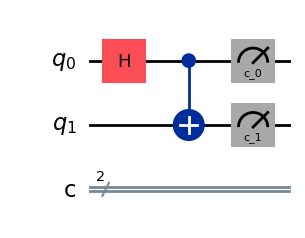

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)

qc.measure([0, 1], [0, 1])
circuit_drawer(qc, output='mpl', measure_arrows=False)

In [2]:
from qiskit.quantum_info import Operator, Pauli
from scipy.linalg import expm
import numpy as np

# Define Hamiltonian (Z Pauli operator)
H = Pauli("Z").to_matrix()

# Define time and ħ = 1 for simplicity
t = np.pi / 4
U = expm(-1j * H * t)  # e^{-iHt}

print(np.round(U, 3))


[[0.707-0.707j 0.   +0.j   ]
 [0.   +0.j    0.707+0.707j]]


In [3]:
ZZ = Pauli("ZZ")
ZI = Pauli("ZI")
IZ = Pauli("IZ")
XX = Pauli("XX")
XI = Pauli("XI")
IX = Pauli("IX")

observables = [ZZ, ZI, IZ, XX, XI, IX]

# Optimize

# Execute

In [4]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)
job.result()

EstimatorResult(values=array([ 1.        , -0.03515625, -0.03515625,  1.        , -0.02539062,
       -0.02539062]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000509125, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.001268, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9987640380859375, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000509125, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1

# Post processing and plotting

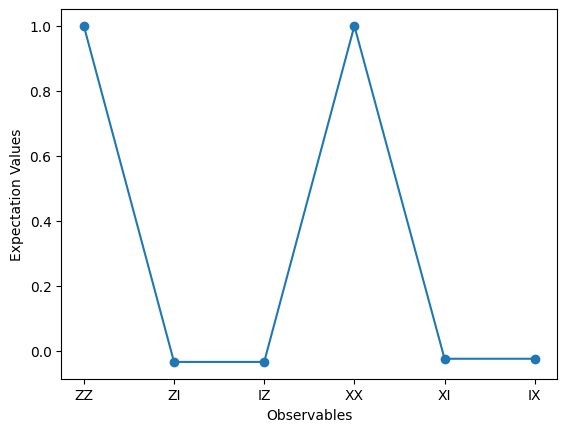

In [5]:
import matplotlib.pyplot as plt

data = ["ZZ", "ZI", "IZ", "XX", "XI", "IX"]
values = job.result().values

plt.plot(data, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Expectation Values")
plt.show()

# Extend the Hello World to an $n$-qubit GHZ state

In [6]:
from qiskit.quantum_info import Pauli
p = Pauli("Y")
print(p)
print(p.to_matrix())

Y
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]


## Step 1: Map the problem to circuits and operators

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

n = 10
qc = get_qc_for_n_qubit_GHZ_state(n)

# Correct operator strings: Z_i * Z_{i+1}
operator_strings = [
    'I'*i + 'Z' + 'I'*(n - i - 2) + 'Z'
    for i in range(n-1)
]

print(len(operator_strings), "operators created")
print(len(operator_strings[0]), "characters per operator")

operators = [SparsePauliOp(op) for op in operator_strings]


9 operators created
10 characters per operator


## Step 1.1: Setup IBM Cloud and Quantum Instance Configuration

In [8]:
# !pip3 install qiskit qiskit-aer

In [9]:
# !pip3 install -U qiskit-ibm-runtime

In [10]:
import os
import json

def load_env_from_json(file_path: str):
    """
    Loads all key-value pairs from a JSON file into environment variables.

    Args:
        file_path (str): Path to the JSON configuration file.
    """
    try:
        with open(file_path, 'r') as f:
            config = json.load(f)

        for key, value in config.items():
            os.environ[key] = str(value)

        print(f"✅ Loaded {len(config)} environment variables from {file_path}")

    except FileNotFoundError:
        print(f"❌ Config file not found: {file_path}")
    except json.JSONDecodeError:
        print(f"❌ Invalid JSON format in: {file_path}")

In [11]:
load_env_from_json("/Users/deneshmani/Documents/src/qc/qiskit-tutorial/apikey.json")

✅ Loaded 5 environment variables from /Users/deneshmani/Documents/src/qc/qiskit-tutorial/apikey.json


In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

# For IBM Quantum public systems
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=os.environ['IBM_API_KEY'],
    overwrite=True
)

In [13]:
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=os.environ['IBM_API_KEY'],
    instance=os.environ['IBM_QUANTUM_INSTANCE_URI'],
    overwrite=True
)


## Step 2: Optimize the problem for Quantum Execution

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_torino"

service = QiskitRuntimeService(channel="ibm_quantum_platform")
print(service.backends())

backend = service.backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]



management.get:WARNING:2025-11-19 05:38:00,033: Loading default saved account


IBMInputValueError: 'No matching instances found for the following filters: .'

## Step 3: Execute on the backend

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()

print(job_id)

d45iu59me48c73d77no0
